In [1]:
import tensorflow as tf
import os 
import matplotlib.pyplot as plt 
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import numpy as np 
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from math import log10, sqrt
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
IMG_SHAPE =(512,512)
IMG=(512,512,1)

In [3]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i],cmap='gray')
        plt.axis('off')
    plt.show()

In [4]:
images=[]
masks=[]

folders=[]
for root, dirs, files in os.walk("/content/gdrive/My Drive/segmentation"):
  folders.append(dirs)

print("========================")

for root, dirs, files in os.walk(f'/content/gdrive/My Drive/segmentation/train_png'):
  filenames=files

filenames.sort()

for name in filenames:
  imgPath=f'/content/gdrive/My Drive/segmentation/train_png/{name}'
  print(imgPath)
  img=load_img(imgPath,target_size=IMG_SHAPE,color_mode='grayscale')
  x=img_to_array(img)
  images.append(x)
print("========================")


for root, dirs, files in os.walk(f'/content/gdrive/My Drive/segmentation/label_png'):

  filenames=files

filenames.sort()
for name in filenames:
  imgPath=f'/content/gdrive/My Drive/segmentation/label_png/{name}'
  print(imgPath)
  img=load_img(imgPath,target_size=IMG_SHAPE,color_mode='grayscale')
  x=img_to_array(img)
  masks.append(x)

/content/gdrive/My Drive/segmentation/train_png/0.png
/content/gdrive/My Drive/segmentation/train_png/0_GaussianNoise.png
/content/gdrive/My Drive/segmentation/train_png/0_rot.png
/content/gdrive/My Drive/segmentation/train_png/0_vflip.png
/content/gdrive/My Drive/segmentation/train_png/1.png
/content/gdrive/My Drive/segmentation/train_png/10.png
/content/gdrive/My Drive/segmentation/train_png/10_GaussianNoise.png
/content/gdrive/My Drive/segmentation/train_png/10_rot.png
/content/gdrive/My Drive/segmentation/train_png/10_vflip.png
/content/gdrive/My Drive/segmentation/train_png/11.png
/content/gdrive/My Drive/segmentation/train_png/11_GaussianNoise.png
/content/gdrive/My Drive/segmentation/train_png/11_rot.png
/content/gdrive/My Drive/segmentation/train_png/11_vflip.png
/content/gdrive/My Drive/segmentation/train_png/12.png
/content/gdrive/My Drive/segmentation/train_png/12_GaussianNoise.png
/content/gdrive/My Drive/segmentation/train_png/12_rot.png
/content/gdrive/My Drive/segmentati

In [5]:
images=np.array(images)
masks=np.array(masks)

images=(images.astype('float')/255)
masks=(masks.astype('float')/255)
masks=np.where(masks > 0.5, 1, 0)


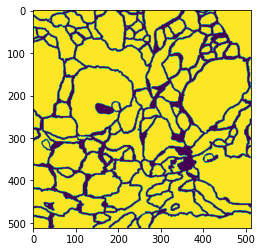

In [6]:
plt.imshow(masks[0].reshape(IMG_SHAPE))

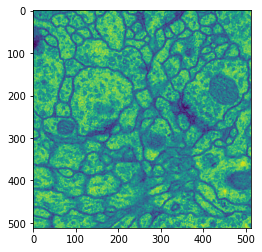

In [7]:
plt.imshow(images[0].reshape(IMG_SHAPE))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    images, masks, test_size=0.10, random_state=42)

## U-net creation

In [9]:
from tensorflow import keras

In [10]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from keras.optimizers import Adam

In [11]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

In [12]:
def plot_fig(train_plot, train_label='', val_plot='', val_label='', title='', x_label='',y_label='', legend_pos='upper right'):
    # create a new figure
    fig = plt.figure()
    
    # plot to it
    plt.plot(train_plot, label=train_label)

    if val_plot:
      plt.plot(val_plot, label=val_label)

    if title:
        plt.title(title)

    if train_label or val_label:
      plt.legend(loc=legend_pos)

    if x_label:
      plt.xlabel(x_label)
    
    if y_label:
      plt.ylabel(y_label)

    # return it
    return fig

In [19]:
inputs = Input((512, 512, 1))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)

c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=["acc"])



model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 512, 512, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 512, 512, 16) 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 512, 512, 16) 2320        dropout_18[0][0]                 
____________________________________________________________________________________________

In [20]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_acc',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.5,
    patience=15,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [21]:
h=model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=200,callbacks=callbacks)

Epoch 1/200
4/4 [==============================] - 8s 1s/step - loss: 0.5394 - acc: 0.7517 - val_loss: 0.4347 - val_acc: 0.7862
Epoch 2/200
4/4 [==============================] - 1s 320ms/step - loss: 0.4584 - acc: 0.7830 - val_loss: 0.3997 - val_acc: 0.7979
Epoch 3/200
4/4 [==============================] - 1s 322ms/step - loss: 0.4195 - acc: 0.8093 - val_loss: 0.3575 - val_acc: 0.8272
Epoch 4/200
4/4 [==============================] - 1s 318ms/step - loss: 0.3747 - acc: 0.8259 - val_loss: 0.3356 - val_acc: 0.8415
Epoch 5/200
4/4 [==============================] - 1s 320ms/step - loss: 0.3553 - acc: 0.8358 - val_loss: 0.3677 - val_acc: 0.8401
Epoch 6/200
4/4 [==============================] - 1s 319ms/step - loss: 0.3482 - acc: 0.8426 - val_loss: 0.6431 - val_acc: 0.8047
Epoch 7/200
4/4 [==============================] - 1s 318ms/step - loss: 0.3444 - acc: 0.8462 - val_loss: 0.3475 - val_acc: 0.8392
Epoch 8/200
4/4 [==============================] - 1s 320ms/step - loss: 0.3458 - acc:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'bottom_right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


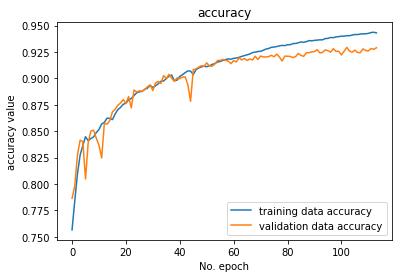

In [31]:
plot_loss = plot_fig(h.history['acc'],'training data accuracy',h.history['val_acc'],'validation data accuracy','accuracy','No. epoch','accuracy value',legend_pos='bottom_right')

In [32]:
def display(i):
  array=model.predict(X_test)[i].reshape(IMG_SHAPE)
  array=np.where(array>0.5,1.0,0)
  display_sample([X_test[i].reshape(IMG_SHAPE),y_test[i].reshape(IMG_SHAPE),array])


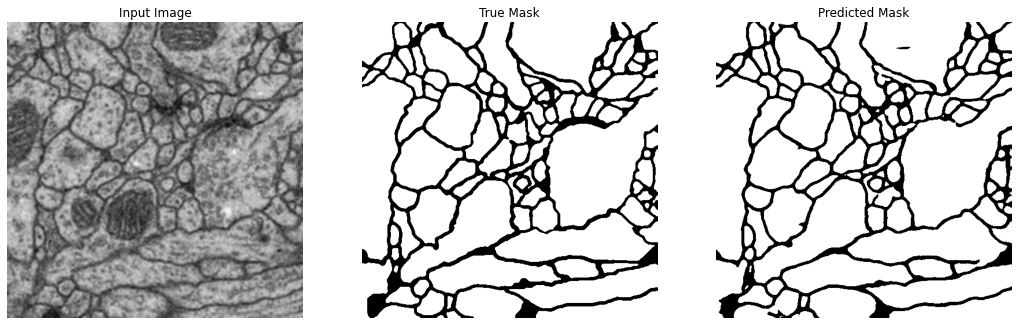

In [33]:
display(4)